In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from multiprocessing import Queue as MultiQueue
from queue import Queue
from urllib.parse import urlparse
from requests import get

from bs4 import BeautifulSoup

## Crawler

In [2]:
class Crawler:
    def __init__(self, seed_urls: str):
        self.q = Queue()
        for url in seed_urls:
            self.q.put(url)
        self.visited_urls = set()
        self.error_urls = set()
        self.visited_pages = dict()

    def _get_unvisited_links(self, page_url: str, page: BeautifulSoup):
        def is_internal(link):
            return not bool(urlparse(link).netloc) or link.startswith(page_url)
        links = {a.get('href', '') for a in page.find_all('a')}
        links = [link for link in links if len(link) > 0]
        for link in links:
            if is_internal(link) and not link.startswith('#'):
                link = f'{page_url}{link}'
            if link.startswith('//'):
                link = f'https:{link}'
            if link not in self.visited_urls:
                yield link

    def _crawl_single(self, url):
        # making the request to the page
        resp = get(url)
        resp.raise_for_status()
        self.visited_urls.add(url)

        # parsing it using bs
        page = BeautifulSoup(resp.content, "html.parser")
        self.visited_pages[url] = page

        # adding links to the bfs queue
        for link in self._get_unvisited_links(url, page):
            self.q.put(link)

    def crawl(self, num_pages: int|None=50):
        num_crawled = 0
        num_error = 0
        while not self.q.empty() and num_crawled + num_error < num_pages:
            url = self.q.get()
            try:
                self._crawl_single(url)
                print(f"visited #{num_crawled+1}: {url}")
                num_crawled += 1
            except Exception as e:
                self.error_urls.add(url)
                print(f'could not visit {url}; exception: {e}')
                num_error += 1

In [3]:
class ConcurrentCrawler(Crawler):
    def __init__(self, seed_urls: str):
        self.q = MultiQueue()
        for url in seed_urls:
            self.q.put(url)
        self.visited_urls = set()
        self.error_urls = set()
        self.visited_pages = dict()

    def _crawl_single(self, url):
        # making the request to the page
        resp = get(url)
        resp.raise_for_status()
        self.visited_urls.add(url)

        # parsing it using bs
        page = BeautifulSoup(resp.content, "html.parser")
        self.visited_pages[url] = page

        # adding links to the bfs queue
        for link in self._get_unvisited_links(url, page):
            self.q.put(link, block=True)

    def crawl(self, num_pages: int|None=50):
        num_crawled = 0
        num_error = 0
        while not self.q.empty() and num_crawled + num_error < num_pages:
            url = self.q.get(block=False)
            try:
                self._crawl_single(url)
                print(f"visited #{num_crawled+1}: {url}")
                num_crawled += 1
            except Exception as e:
                self.error_urls.add(url)
                print(f'could not visit {url}; exception: {e}')
                num_error += 1

## Accessibility Evaluation

In [4]:
def alt_tag_percentage(bso) -> float:
    img_tags = bso.find_all('img')
    img_tags_with_alt = [tag for tag in img_tags if tag.has_attr('alt')]
    return len(img_tags_with_alt) / len(img_tags) if len(img_tags) > 0 else 1

In [5]:
def aria_label_links_percentage(bso) -> float:
    a_tags = bso.find_all('a')
    a_tags_with_aria_label = [tag for tag in a_tags if tag.has_attr('aria-label')]
    return len(a_tags_with_aria_label) / len(a_tags) if len(a_tags) > 0 else 1

## Crawling NY-Mag and Wikpedia

In [6]:
c1 = Crawler(seed_urls=['https://nymag.com', 'https://en.wikipedia.org/wiki/Main_Page'])
c1.crawl(100)

visited #1: https://nymag.com
visited #2: https://en.wikipedia.org/wiki/Main_Page
could not visit https://nymag.comhttps://nymag.com/aboutus/; exception: HTTPSConnectionPool(host='nymag.comhttps', port=443): Max retries exceeded with url: //nymag.com/aboutus/ (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f830273ca50>: Failed to establish a new connection: [Errno -2] Name or service not known'))
visited #3: https://www.vulture.com/article/summer-house-recap-season-7-episode-3-a-cup-of-loyaltea.html
visited #4: https://thecut.com/self
visited #5: https://subs.nymag.com/account/
visited #6: https://nymag.com/intelligencer/business/
visited #7: https://nymag.com/intelligencer/2023/02/the-everything-guide-to-george-santoss-lies.html
visited #8: https://www.vulture.com/2023/02/cocaine-bear-star-keri-russell-on-the-americans-reunion.html
visited #9: https://www.curbed.com/article/best-pet-supply-stores-nyc.html
visited #10: https://vulture.com/music/
visited 

In [7]:
c2 = ConcurrentCrawler(seed_urls=['https://nymag.com', 'https://en.wikipedia.org/wiki/Main_Page'])
c2.crawl(100)

visited #1: https://nymag.com
visited #2: https://en.wikipedia.org/wiki/Main_Page
could not visit https://nymag.comhttps://nymag.com/aboutus/; exception: HTTPSConnectionPool(host='nymag.comhttps', port=443): Max retries exceeded with url: //nymag.com/aboutus/ (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7f82f309b810>: Failed to establish a new connection: [Errno -2] Name or service not known'))
visited #3: https://www.vulture.com/article/summer-house-recap-season-7-episode-3-a-cup-of-loyaltea.html
visited #4: https://thecut.com/self
visited #5: https://subs.nymag.com/account/
visited #6: https://nymag.com/intelligencer/business/
visited #7: https://nymag.com/intelligencer/2023/02/the-everything-guide-to-george-santoss-lies.html
visited #8: https://www.vulture.com/2023/02/cocaine-bear-star-keri-russell-on-the-americans-reunion.html
visited #9: https://www.curbed.com/article/best-pet-supply-stores-nyc.html
visited #10: https://vulture.com/music/
visited 

In [8]:
results = pd.DataFrame()
for i, (url, page) in enumerate(c1.visited_pages.items()):
    results.loc[i, 'url'] = url
    results.loc[i, 'alt_text_percentage'] = alt_tag_percentage(page)
    results.loc[i, 'aria_label_percentage'] = aria_label_links_percentage(page)
results

,url,alt_text_percentage,aria_label_percentage
0,https://nymag.com,1.000000,0.002639
1,https://en.wikipedia.org/wiki/Main_Page,1.000000,0.003021
2,https://www.vulture.com/article/summer-house-r...,0.888889,0.172222
3,https://thecut.com/self,1.000000,0.008197
4,https://subs.nymag.com/account/,1.000000,0.012500
...,...,...,...
86,https://nymag.com/strategist/home,1.000000,0.005464
87,https://www.grubstreet.com/2023/02/nyc-city-co...,0.892857,0.183673
88,https://www.vulture.com/,1.000000,0.005291
89,https://nymag.com/intelligencer/ideas/,1.000000,0.010526


In [9]:
len(results)

91

In [10]:
results.to_csv('nymag-wikipedia.csv')

## Plotting

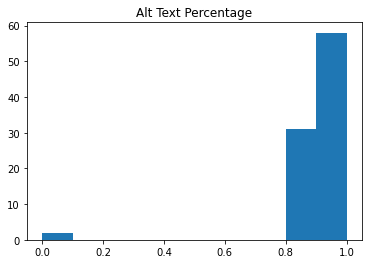

In [11]:
plt.hist(results['alt_text_percentage'])
plt.title('Alt Text Percentage')
plt.show()

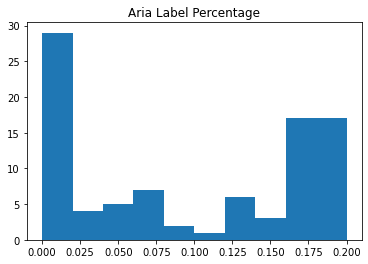

In [12]:
plt.hist(results['aria_label_percentage'])
plt.title('Aria Label Percentage')
plt.show()